### (Optional) Install Neural A* on Colab

We highly recommend the use of GPUs for faster training/planning.

In [1]:
!git clone --recursive https://github.com/omron-sinicx/neural-astar

Cloning into 'neural-astar'...
remote: Enumerating objects: 424, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 424 (delta 20), reused 11 (delta 11), pack-reused 385
Receiving objects: 100% (424/424), 11.23 MiB | 4.22 MiB/s, done.
Resolving deltas: 100% (177/177), done.
Submodule 'planning-datasets' (https://github.com/omron-sinicx/planning-datasets) registered for path 'planning-datasets'
Cloning into '/home/sam/Desktop/Tesi/neural-astar/notebooks/neural-astar/planning-datasets'...
remote: Enumerating objects: 51, done.        
remote: Counting objects: 100% (10/10), done.        
remote: Compressing objects: 100% (8/8), done.        
remote: Total 51 (delta 4), reused 4 (delta 2), pack-reused 41        
Receiving objects: 100% (51/51), 58.10 MiB | 3.06 MiB/s, done.
Resolving deltas: 100% (7/7), done.
Submodule path 'planning-datasets': checked out '7f8953c4b0f511c2cc03410abfdb3687d54deafb'
Submodule 'data/mpd/origina

In [2]:
%cd neural-astar
!pip install -U pip setuptools
!pip install .

/home/sam/Desktop/Tesi/neural-astar/notebooks/neural-astar
Processing /home/sam/Desktop/Tesi/neural-astar/notebooks/neural-astar
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


  Created wheel for neural_astar: filename=neural_astar-0.2.0-py3-none-any.whl size=14373 sha256=68d266967ce19d96df6bbd2f66af2e5504d49e3de8f151585862407780de815f
  Stored in directory: /home/sam/.cache/pip/wheels/84/2c/12/180aa8c7c640015fff123429db2259095664be61e6ead16b3c
Successfully built neural_astar
  Attempting uninstall: neural_astar
    Found existing installation: neural_astar 0.2.0
    Uninstalling neural_astar-0.2.0:
      Successfully uninstalled neural_astar-0.2.0


## Shortest path search with Neural A* 

Neural A\*, as well as vanilla differentiable A\* can be instantiated just like a neural network module.

In [1]:
import torch
from neural_astar.planner import NeuralAstar, VanillaAstar
from neural_astar.utils.training import load_from_ptl_checkpoint

device = "cuda" if torch.cuda.is_available() else "cpu"

neural_astar = NeuralAstar(encoder_arch='CNN').to(device)
neural_astar.load_state_dict(load_from_ptl_checkpoint("../model/mazes_032_moore_c8/lightning_logs/"))

vanilla_astar = VanillaAstar().to(device)

c:\Users\User\Desktop\uni\Tesi\neural-astar\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


load ../model/mazes_032_moore_c8/lightning_logs\version_0\checkpoints\epoch=33-step=272.ckpt


Running these A\* modules requires `map_designs` (obstacle layouts), `start_maps`, and `goal_maps` (one-hot maps indicating start and goal locations), which should each have the shape of `(batch_size, 1, map_size, map_size)`.

Number of Test Samples: 100
	Size: 32x32


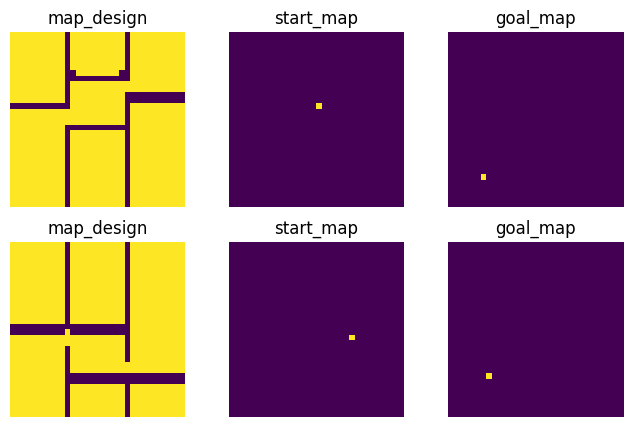

In [8]:
import matplotlib.pyplot as plt
from neural_astar.utils.data import create_dataloader

dataloader = create_dataloader("../planning-datasets/data/mpd/mazes_032_moore_c8.npz", "test", 8)
map_designs, start_maps, goal_maps, _ = next(iter(dataloader))

fig, axes = plt.subplots(2, 3, figsize=[8, 5])
for i in range(2):
    axes[i, 0].imshow(map_designs.numpy()[i, 0])
    axes[i, 0].set_title("map_design")
    axes[i, 0].axis("off")
    axes[i, 1].imshow(start_maps.numpy()[i, 0])
    axes[i, 1].set_title("start_map")
    axes[i, 1].axis("off")
    axes[i, 2].imshow(goal_maps.numpy()[i, 0])
    axes[i, 2].set_title("goal_map")
    axes[i, 2].axis("off")

Then, search can be performed by simply forwarding the model. The output is namedtuple `AstarOutput` with `histories` (search history maps) and `paths` (path maps).

/home/sam/Desktop/Tesi/neural-astar/.venv/lib/python3.8/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


(-0.5, 273.5, 35.5, -0.5)

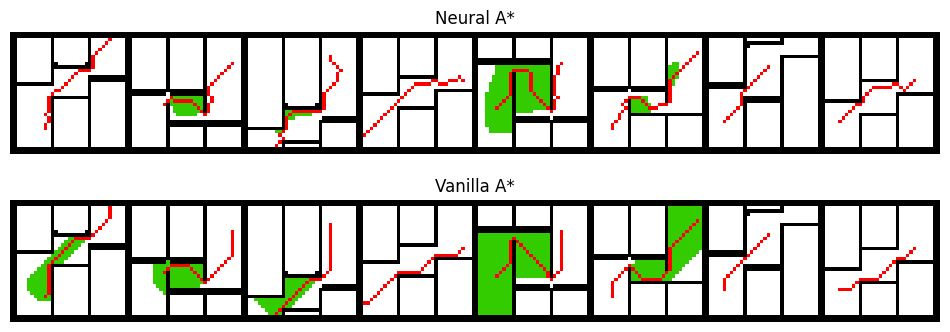

In [3]:
from neural_astar.utils.data import visualize_results

neural_astar.eval()
na_outputs = neural_astar(map_designs.to(device), start_maps.to(device), goal_maps.to(device))
vanilla_astar.eval()
va_outputs = vanilla_astar(map_designs.to(device), start_maps.to(device), goal_maps.to(device))

fig, axes = plt.subplots(2, 1, figsize=[12, 4])
axes[0].imshow(visualize_results(map_designs, na_outputs))
axes[0].set_title("Neural A*")
axes[0].axis("off")
axes[1].imshow(visualize_results(map_designs, va_outputs))
axes[1].set_title("Vanilla A*")
axes[1].axis("off")